In [1]:
import torch
import sys
from tqdm.auto import tqdm

print(torch.__version__)
print("cuda available:", torch.cuda.is_available())

2.5.1
cuda available: False


C:\Users\11604\anaconda3\envs\haptics-ae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(sys.executable)

C:\Users\11604\anaconda3\envs\haptics-ae\python.exe


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

print("numpy:", np.__version__)
print("torch:", torch.__version__)

numpy: 2.2.5
torch: 2.5.1


Dataset shape: (5000, 1000)


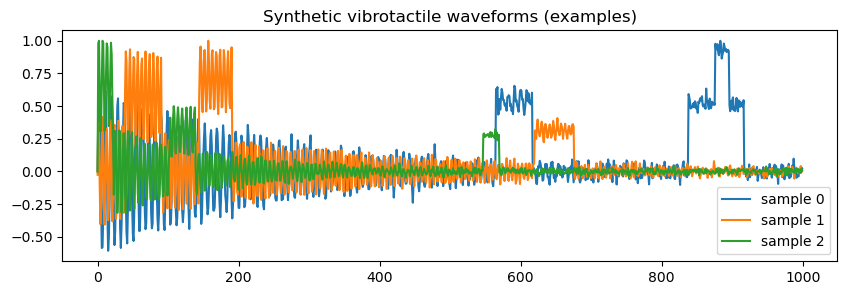

In [4]:
def make_vibration(sample_rate=1000, duration=1.0):
    """
    生成一条合成震动波形（长度 T = sample_rate * duration）
    组合：正弦 + 衰减包络 + 可选脉冲 + 少量噪声
    """
    T = int(sample_rate * duration)
    t = np.linspace(0, duration, T, endpoint=False)

    # 随机参数
    freq = np.random.uniform(80, 250)          # Hz
    amp = np.random.uniform(0.1, 1.0)          # amplitude
    decay = np.random.uniform(1.5, 8.0)        # 衰减速度
    
    # 基础正弦 + 衰减包络
    envelope = np.exp(-decay * t)
    vib = amp * envelope * np.sin(2 * np.pi * freq * t)

    # 可选：加入 0~3 个脉冲（模拟 tap）
    num_pulses = np.random.randint(0, 4)
    for _ in range(num_pulses):
        start = np.random.randint(0, T - 60)
        width = np.random.randint(20, 80)
        pulse_amp = np.random.uniform(0.2, 1.0)
        vib[start:start+width] += pulse_amp

    # 加一点噪声（更像真实）
    vib += np.random.normal(0, 0.02, size=T)

    # 归一化到 [-1, 1] 附近（训练更稳定）
    max_abs = np.max(np.abs(vib)) + 1e-8
    vib = vib / max_abs
    
    return vib.astype(np.float32)

# 生成数据集，5000条，每条一秒，采样率1000Hz
N = 5000
sample_rate = 1000
duration = 1.0
T = int(sample_rate * duration)

X = np.stack([make_vibration(sample_rate, duration) for _ in range(N)], axis=0)  # (N, T)
print("Dataset shape:", X.shape)

# 看几条例子
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.plot(X[i], label=f"sample {i}")
plt.title("Synthetic vibrotactile waveforms (examples)")
plt.legend()
plt.show()

In [5]:
# 切分 train/val
perm = np.random.permutation(N)
train_idx = perm[:int(0.8 * N)]
val_idx = perm[int(0.8 * N):]

X_train = torch.from_numpy(X[train_idx])
X_val = torch.from_numpy(X[val_idx])

X_train_cnn = X_train.unsqueeze(1)  # (N, 1, T)
X_val_cnn   = X_val.unsqueeze(1)    # (N, 1, T)

train_loader = DataLoader(TensorDataset(X_train_cnn), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_cnn), batch_size=128, shuffle=False)

print("Train batch example shape:", next(iter(train_loader))[0].shape)  # (B, 1, T)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Train batch example shape: torch.Size([128, 1, 1000])
Device: cpu


In [6]:
import torch
import torch.nn as nn

class ConvAE(nn.Module):
    def __init__(self, input_len=1000, latent_dim=16):
        super().__init__()
        self.input_len = input_len
        self.latent_dim = latent_dim

        # Encoder: (B, 1, 1000) -> (B, 64, 125)
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4),  # 1000 -> 500
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4), # 500 -> 250
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4), # 250 -> 125
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        # 把卷积输出 flatten 后映射到 latent
        self.enc_feat_len = 64 * 125
        self.fc_enc = nn.Linear(self.enc_feat_len, latent_dim)

        # Decoder: latent -> (B, 64, 125) -> (B, 1, 1000)
        self.fc_dec = nn.Linear(latent_dim, self.enc_feat_len)

        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1),  # 125 -> 250
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1),  # 250 -> 500
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1,  kernel_size=9, stride=2, padding=4, output_padding=1),  # 500 -> 1000
            # nn.Tanh(),  # 输出约束到[-1,1]
        )

    def forward(self, x):
        # x: (B, 1, T)
        h = self.encoder_conv(x)                    # (B, 64, 125)
        h_flat = h.view(h.size(0), -1)              # (B, 64*125)
        z = self.fc_enc(h_flat)                     # (B, latent_dim)

        h2 = self.fc_dec(z).view(x.size(0), 64, 125)  # (B, 64, 125)
        x_hat = self.decoder_deconv(h2)             # (B, 1, 1000)

        return x_hat, z

# 创建模型
T = 1000
latent_dim = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE(input_len=T, latent_dim=latent_dim).to(device)
print(model)

# 快速 sanity check：输出长度是否正确
with torch.no_grad():
    test_x = torch.randn(4, 1, T).to(device)
    test_hat, test_z = model(test_x)
    print("Input:", test_x.shape, "Output:", test_hat.shape, "Latent:", test_z.shape)


ConvAE(
  (encoder_conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_enc): Linear(in_features=8000, out_features=16, bias=True)
  (fc_dec): Linear(in_features=16, out_features=8000, bias=True)
  (decoder_deconv): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(32, 16, kernel_size=(9,), stride=(2,), padding

In [7]:
import torch.nn.functional as F

def fft_mag_mse(x_hat, x, eps=1e-8, use_log=True):
    """
    x_hat, x: (B, 1, T)  # Conv1D AE 的输出形状
    返回：频域幅度谱的 MSE
    """
    # rfft: 实数FFT，输出长度约 T/2+1
    Xh = torch.fft.rfft(x_hat, dim=-1)
    X  = torch.fft.rfft(x, dim=-1)

    mag_h = torch.abs(Xh)
    mag   = torch.abs(X)

    if use_log:
        mag_h = torch.log(mag_h + eps)
        mag   = torch.log(mag + eps)

    return F.mse_loss(mag_h, mag)


In [8]:
import os

ckpt_path = "conv1d_fft_checkpoint.pt"   # ✅ 换名，重新跑更干净

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

total_epochs = 60
print_every = 5          # ✅ 每 5 个 epoch 打印一次汇总
patience = 6
min_delta = 5e-4
alpha = 0.05

In [9]:
def run_epoch(loader, train=True, alpha=0.02, epoch=None):
    model.train(train)
    total_loss = 0.0
    count = 0

    mode = "train" if train else "val"

    # ✅ tqdm：每个 batch 更新一次 → epoch 没结束也能看到进度在动
    pbar = tqdm(loader, leave=False, desc=f"{mode} epoch {epoch}")

    for (x,) in pbar:
        x = x.to(device)
        if train:
            optimizer.zero_grad()

        x_hat, _ = model(x)

        time_loss = criterion(x_hat, x)
        freq_loss = fft_mag_mse(x_hat, x, use_log=True)
        loss = time_loss + alpha * freq_loss

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        count += x.size(0)

        # ✅ 进度条右侧实时显示当前平均 loss（会动）
        pbar.set_postfix(loss=f"{(total_loss/count):.4f}")

    return total_loss / count


In [10]:
start_epoch = 1
train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
wait = 0

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scheduler.load_state_dict(ckpt["scheduler"])

    start_epoch = ckpt["epoch"] + 1
    train_losses = ckpt["train_losses"]
    val_losses = ckpt["val_losses"]

    best_val = ckpt["best_val"]
    best_state = ckpt["best_state"]
    wait = ckpt["wait"]

    print(f"✅ Resumed from epoch {ckpt['epoch']} (next={start_epoch})")
else:
    print("🆕 No checkpoint found, training from scratch.")


🆕 No checkpoint found, training from scratch.


In [11]:
for epoch in range(start_epoch, total_epochs + 1):
    tr = run_epoch(train_loader, train=True,  alpha=alpha, epoch=epoch)
    va = run_epoch(val_loader,   train=False, alpha=alpha, epoch=epoch)

    train_losses.append(tr)
    val_losses.append(va)

    scheduler.step(va)
    lr = optimizer.param_groups[0]["lr"]

    # ✅ 只在每个 stage 结束时打印（你要的“只每五个打印一次”）
    if epoch % print_every == 0 or epoch == start_epoch:
        print(
            f"[Epoch {epoch:03d}/{total_epochs} | stage progress: 100%] "
            f"lr={lr:.2e} | train={tr:.6f} | val={va:.6f}"
        )

    model.eval()
    with torch.no_grad():
        (x0,) = next(iter(val_loader))
        x0 = x0.to(device)
        x0_hat, _ = model(x0)
        tl = criterion(x0_hat, x0).item()
        fl = fft_mag_mse(x0_hat, x0, use_log=True).item()
    print(f"    (val breakdown) time={tl:.4f} | fft={fl:.4f} | alpha*fft={alpha*fl:.4f}")


    # ✅ early stopping
    if va < best_val - min_delta:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1

    # ✅ 保存 checkpoint
    torch.save(
        {
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "best_val": best_val,
            "best_state": best_state,
            "wait": wait,
        },
        ckpt_path,
    )

    if wait >= patience:
        print(f"⏹️ Early stopping at epoch {epoch}, best val = {best_val:.6f}")
        break


[Epoch 001/60 | stage progress: 100%] lr=1.00e-03 | train=0.377538 | val=0.139101
    (val breakdown) time=0.0755 | fft=1.3083 | alpha*fft=0.0654


    (val breakdown) time=0.0738 | fft=1.0254 | alpha*fft=0.0513


    (val breakdown) time=0.0744 | fft=0.8953 | alpha*fft=0.0448


    (val breakdown) time=0.0747 | fft=0.8520 | alpha*fft=0.0426


[Epoch 005/60 | stage progress: 100%] lr=1.00e-03 | train=0.117737 | val=0.115845
    (val breakdown) time=0.0746 | fft=0.8091 | alpha*fft=0.0405


    (val breakdown) time=0.0732 | fft=0.7687 | alpha*fft=0.0384


    (val breakdown) time=0.0742 | fft=0.7875 | alpha*fft=0.0394


    (val breakdown) time=0.0745 | fft=0.7513 | alpha*fft=0.0376


    (val breakdown) time=0.0756 | fft=0.7526 | alpha*fft=0.0376


[Epoch 010/60 | stage progress: 100%] lr=1.00e-03 | train=0.112646 | val=0.109920
    (val breakdown) time=0.0734 | fft=0.7405 | alpha*fft=0.0370


    (val breakdown) time=0.0737 | fft=0.7285 | alpha*fft=0.0364


    (val breakdown) time=0.0726 | fft=0.6771 | alpha*fft=0.0339


    (val breakdown) time=0.0727 | fft=0.6894 | alpha*fft=0.0345


    (val breakdown) time=0.0726 | fft=0.6766 | alpha*fft=0.0338


[Epoch 015/60 | stage progress: 100%] lr=1.00e-03 | train=0.104198 | val=0.101823
    (val breakdown) time=0.0721 | fft=0.6392 | alpha*fft=0.0320


    (val breakdown) time=0.0741 | fft=0.6749 | alpha*fft=0.0337


    (val breakdown) time=0.0724 | fft=0.6839 | alpha*fft=0.0342


    (val breakdown) time=0.0736 | fft=0.6885 | alpha*fft=0.0344


    (val breakdown) time=0.0725 | fft=0.6655 | alpha*fft=0.0333
⏹️ Early stopping at epoch 19, best val = 0.101823


✅ Saved best model weights to conv1d_fft_best_model.pt


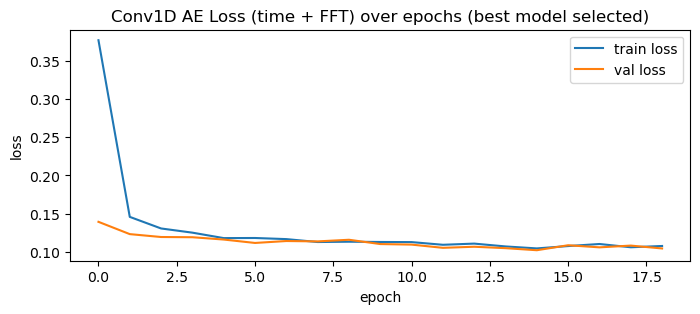

Best val loss: 0.10182322573661805


In [12]:
# 恢复最佳模型
model.load_state_dict(best_state)
model.to(device)
torch.save(best_state, "conv1d_fft_best_model.pt")
print("✅ Saved best model weights to conv1d_fft_best_model.pt")

# 画 loss 曲线
plt.figure(figsize=(8, 3))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.title("Conv1D AE Loss (time + FFT) over epochs (best model selected)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

print("Best val loss:", best_val)

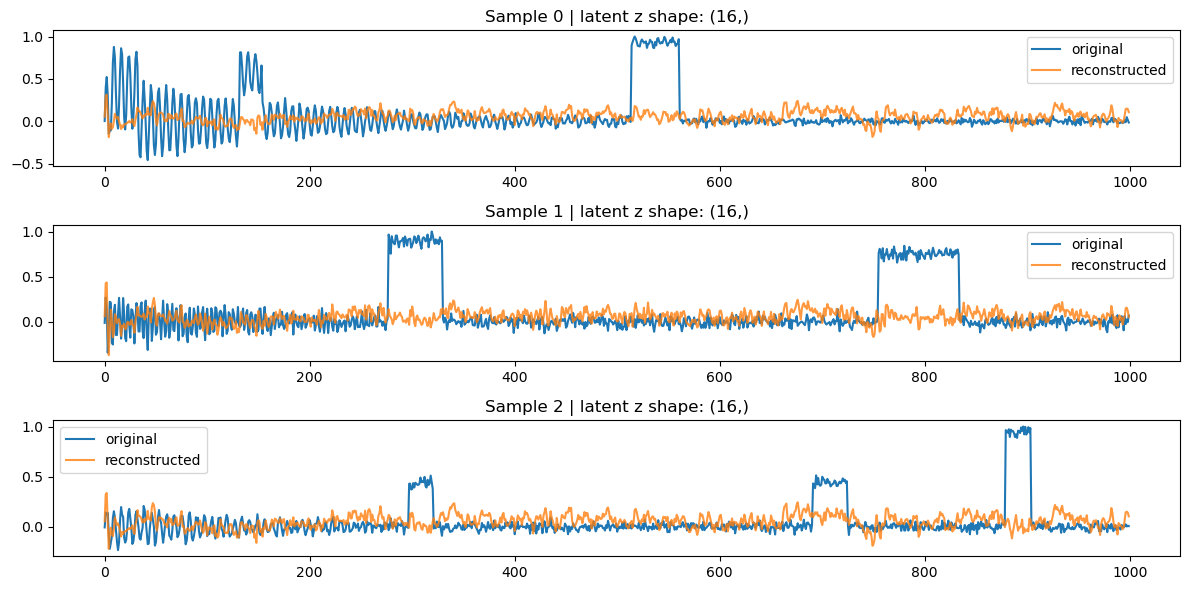

Example latent z (first sample): [-0.96328735  1.6177381  -5.80735     0.9181306   4.7804193  13.135204
  5.6676517   2.3519912  -0.33114442  6.6356363  -4.9812927  -2.6289766
 -5.4925346   3.6283636  -0.06327135  2.455198  ]


In [13]:
model.eval()
with torch.no_grad():
    x = X_val_cnn[:5].to(device)            # (5,1,T)
    x_hat, z = model(x)

    x = x[:, 0, :].cpu().numpy()            # (5,T)
    x_hat = x_hat[:, 0, :].cpu().numpy()    # (5,T)
    z = z.cpu().numpy()

num_show = 3
plt.figure(figsize=(12, 6))
for i in range(num_show):
    plt.subplot(num_show, 1, i+1)
    plt.plot(x[i], label="original")
    plt.plot(x_hat[i], label="reconstructed", alpha=0.8)
    plt.title(f"Sample {i} | latent z shape: {z[i].shape}")
    plt.legend()
plt.tight_layout()
plt.show()

print("Example latent z (first sample):", z[0])
